# Learning US senators voting behavior from bills sponsorship profile

This notebook contains the curated content of the Networks Tour of Data Science 2018 final project.

- Exploratory data analysis
- Exploitation
    - Graph CNN
    - Transductive Learning

## 1 Exploratory data analysis

### 1.1 ...

## 2 Senate vote position prediction using transductive learning

Predicting the positions of senators on a given bill, given its cosponsors.

### 2.1 Data preprocessing

In [2]:
import os
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import ast
import scipy
from scipy import sparse
import networkx as nx
from lib import graph
from pyunlocbox import functions, solvers

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import seaborn as sns
%matplotlib inline 
%load_ext autoreload
%autoreload

import warnings # For RandomForestRegressor and matplotlib
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf

from lib import models_alt, graph
tf.logging.set_verbosity(tf.logging.ERROR)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### 2.1.1 Genearting train and test data

The train data will be used to generate the adjacency matrix and train the threshold regressor.

In [2]:
def numeric_votes(vote_position):
    ''' 
    Converts vote positions to numeric values:
        Yes -> 1
        Not voting -> 0
        No -> -1
    '''
    if vote_position == 'Yes':
        return 1
    elif vote_position == 'Not Voting' or pd.isnull(vote_position):
        return 0
    else:
        return -1

def get_train_test(senate_id=115, ratio_train=0.5, ratio_val=0.1, shuffle=False, seed=123):
    '''
    Loads bills and votes and generates training, validation
    and testing data. Inputs are cosponsor vote positions and
    targets are the final vote outcomes.
    '''
    # Load votes and bills
    VOTES_PATH = './data/votes/votes_{}.csv'.format(senate_id)
    BILLS_PATH = './data/bills/bills_{}.csv'.format(senate_id)
    bills = pd.read_csv(BILLS_PATH)
    votes = pd.read_csv(VOTES_PATH)
    
    # Keep only the bills sponsored by Senators
    bills_sen = bills[bills.sponsor_title=='Sen.']
    N_BILLS_SEN = bills_sen.shape[0]
    
    # Get the members
    members_aux = pd.DataFrame(list(votes['member_id'].unique())).rename(columns={0: 'member_id'})
    members = members_aux.merge(votes.drop_duplicates(subset='member_id')[['member_id', 'party']], how='left').sort_values(['party', 'member_id'])
    N_SENATORS = len(members)
                   
    for i,j in enumerate(bills_sen.cosponsors_sen):
        bills_sen.cosponsors_sen.iloc[i] = ast.literal_eval(j)
    
    # Create binary matrices indicating sponsorship
    S = np.zeros((N_BILLS_SEN, N_SENATORS))
    for i, j in enumerate(bills_sen.cosponsors_sen):
        S[i, list(members['member_id']).index(bills_sen.sponsor_id.iloc[i])] = 1
    
    # Create binary matrices indicating cosponsorship
    CS = np.zeros((N_BILLS_SEN, N_SENATORS))
    for i, j in enumerate(bills_sen.cosponsors_sen):
        for k, l in enumerate(bills_sen.cosponsors_sen.iloc[i]):
            CS[i, list(members['member_id']).index(bills_sen.cosponsors_sen.iloc[i][k])] = 1
          
    # Sponsorship mask
    Z = S + CS
    
    # The target Y is the vote position of all senators for a given bill
    Y = np.zeros((N_BILLS_SEN, N_SENATORS))
    for i, l in enumerate(list(bills_sen.vote_uri)):
        votes_i = (members.merge(votes[votes.vote_uri == l], how='left'))
        feature = votes_i.vote_position.apply(numeric_votes).values
        Y[i] = feature
    
    # The input data X is the vote position of all (co)sponsors for a given bill
    X = np.zeros((N_BILLS_SEN, N_SENATORS))
    X[Z==1] = Y[Z==1]
    
    n = X.shape[0]
    d = X.shape[1]
    
    n_train = int(n * ratio_train)
    n_val = int(n * ratio_val)

    if shuffle:
        np.random.seed(seed)
        perm_idx = np.random.permutation(n)
    else:
        perm_idx = np.arange(n)
    X_train = X[perm_idx[:n_train]]
    X_val = X[perm_idx[n_train:n_train+n_val]]
    X_test = X[perm_idx[n_train+n_val:]]

    y_train = Y[perm_idx[:n_train]]
    y_val = Y[perm_idx[n_train:n_train+n_val]]
    y_test = Y[perm_idx[n_train+n_val:]]
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [53]:
data = get_train_test(senate_id=115, ratio_train=0.5, ratio_val=0, shuffle=True)
X_train, X_val, X_test, y_train, y_val, y_test = data

Below we plot one example of how the input and targets look like, with the input only containing the cosponsor positions and the truth containing all final votes.

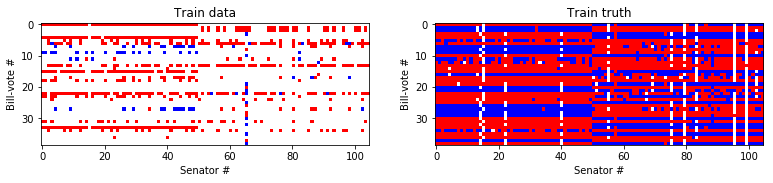

In [54]:
mycmap = ListedColormap(['blue','white','red'])

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(X_train, vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Senator #')
plt.ylabel('Bill-vote #')
plt.title('Train data')
plt.subplot(1,3,2)
plt.imshow(y_train, vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Senator #')
plt.ylabel('Bill-vote #')
plt.title('Train truth');

#### 2.1.2 Computing the adjacency matrix and its gradient

We need to compute the adjacency matrix and the gradient to give to the variation minimization problem.

In [6]:
def compute_adjacency(y, k=15, cutoff=0.01):
    '''
    Computes an adjacency matrix from vote positions by
    using exact pairwise euclidean distances between nodes.
    '''
    dist, idx = graph.distance_scipy_spatial(y.T, k=k, metric='euclidean')
    A = graph.adjacency(dist, idx).astype(np.float32)
    A = (A > cutoff).astype(np.float32)
    return A

# Create the adjacency matrix on the training positions of all senators
A = compute_adjacency(y_train)

d = |V| = 105, k|V| < |E| = 2170


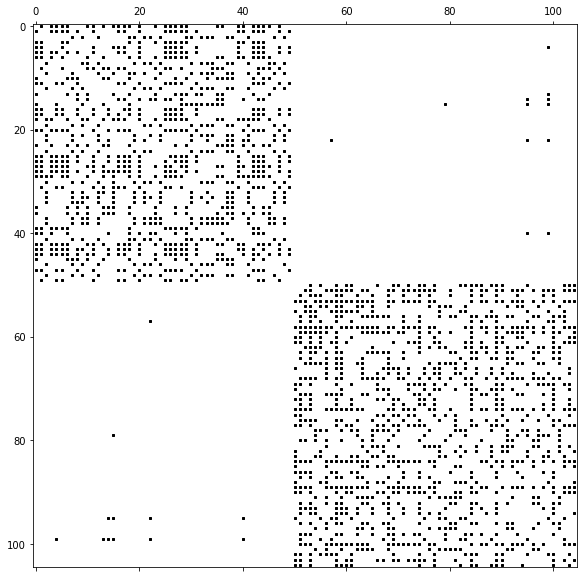

In [7]:
print('d = |V| = {}, k|V| < |E| = {}'.format(A.shape[0], A.nnz))
plt.figure(figsize=(10,10))
plt.spy(A, markersize=2, color='black');

In [10]:
def compute_incident_matrix(A):
    ''' Computes the gradient/incident matrix from the adjacency matrix. '''
    d = A.shape[0]
    S = np.zeros((d, int(A.sum() // 2)))
    edge_idx = 0
    for i in range(d):
        for k in range(i):
            if A[i,k] == 1.0:
                S[i,edge_idx] = 1
                S[k,edge_idx] = -1
                edge_idx += 1
    return S

S = compute_incident_matrix(A)

### 2.2 Transductive learning

#### 2.2.1 Setup for Transductive Learning

Setting up the solver for the transductive learning problem:

In [11]:
def P(a, w, labels):
    '''
    Enforces that the input ground truth labels stay the
    same throughout optimization, by replacing the predicted
    values with the labels.
    '''
    mask_pos = np.where(w==1)
    b = a.copy()
    b[mask_pos] = labels[mask_pos]
    return b

def graph_pnorm_interpolation(gradient, P, w, x0=None, p=1., **kwargs):
    r'''
    Solve an interpolation problem via gradient p-norm minimization.

    A signal :math:`x` is estimated from its measurements :math:`y = A(x)` by solving
    :math:`\text{arg}\underset{z \in \mathbb{R}^n}{\min}
    \| \nabla_G z \|_p^p \text{ subject to } Az = y` 
    via a primal-dual, forward-backward-forward algorithm.

    Parameters
    ----------
    gradient : array_like
        A matrix representing the graph gradient operator
    P : callable
        Orthogonal projection operator mapping points in :math:`z \in \mathbb{R}^n` 
        onto the set satisfying :math:`A P(z) = A z`.
    x0 : array_like, optional
        Initial point of the iteration. Must be of dimension n.
        (Default is `numpy.random.randn(n)`)
    p : {1., 2.}
    kwargs :
        Additional solver parameters, such as maximum number of iterations
        (maxit), relative tolerance on the objective (rtol), and verbosity
        level (verbosity). See :func:`pyunlocbox.solvers.solve` for the full
        list of options.

    Returns
    -------
    x : array_like
        The solution to the optimization problem.

    '''
    
    grad = lambda z: gradient.dot(z)
    div = lambda z: gradient.transpose().dot(z)

    # Indicator function of the set satisfying :math:`y = A(z)`
    f = functions.func()
    f._eval = lambda z: 0
    f._prox = lambda z, gamma: P(z, w, x0)

    # :math:`\ell_1` norm of the dual variable :math:`d = \nabla_G z`
    g = functions.func()
    g._eval = lambda z: np.sum(np.abs(grad(z)))
    g._prox = lambda d, gamma: functions._soft_threshold(d, gamma)

    # :math:`\ell_2` norm of the gradient (for the smooth case)
    h = functions.norm_l2(A=grad, At=div)

    stepsize = (0.9 / (1. + scipy.sparse.linalg.norm(gradient, ord='fro'))) ** p

    solver = solvers.mlfbf(L=grad, Lt=div, step=stepsize)

    if p == 1.:
        problem = solvers.solve([f, g, functions.dummy()], x0=x0, solver=solver, 
                                **kwargs, verbosity='NONE')
        return problem['sol']
    if p == 2.:
        problem = solvers.solve([f, functions.dummy(), h], x0=x0, solver=solver, 
                                **kwargs, verbosity='NONE')
        return problem['sol']
    else:
        return x0
    
def predict_votes(known_votes, S, p=1.):
    ''' Given the cosponsors votes, returns the result of the optimization. '''
    # Mask showing which entries have data
    w = (known_votes != 0).astype(int)  
    sol_min = graph_pnorm_interpolation(sparse.csr_matrix(S).T, P, w, 
                                        x0=known_votes.copy(), p=p)
    return sol_min

#### 2.2.2 Finding optimal thresholds

Because the solutions from the transductive learning problem are not yet binarized into "Yay" and "Nay" vote predictions, we have to pick a threshold for choosing how we bin our predictions. For different outcomes, different thresholds might be optimal. If we knew the optimal threshold, we show below that we can very accurately predict the true vote outcomes, if we only know the cosponsor positions. For this reason, we would like to pick the best threshold at test time, without peaking at how the senators actually voted on a given bill! 

Our strategy of estimating this threshold consists of first building a small dataset in the following way: We iterate over all bills in the training set and generate a vote prediction for all senators from the known cosponsor positions. Knowing the true vote result, we search the threshold for binarizing our predictions that leads to the smallest relative error between prediction and ground truth. This threshold will be the target in our dataset. For features, we collect some statistics about the cosponsors, such as the number of cosponsors in each party and flags if there are or are not any cosponsors in each party.

Using this dataset, we can learn a good threshold value based on some statistics about the cosponsors. We will apply this Machine Learning model to get thresholds on test data.

Now we set up the functions allowing us to search for the best threshold:

In [12]:
def rel_err(truth, preds):
    ''' 
    Calculates the relative error between the true labels and an estimate.
    
    Args:
        truth: Ground truth signal
        preds: Estimated signal
    '''
    voted_idxs = np.where(truth != 0)
    return np.linalg.norm(truth[voted_idxs] - preds[voted_idxs], 2) / np.linalg.norm(truth[voted_idxs], 2)

def compute_acc(truth, preds):
    ''' 
    Calculates the accuracy between the true labels and an estimate.
    
    Args:
        truth: Ground truth signal
        preds: Estimated signal
    '''
    valid_indices = np.where(np.any([truth==1, truth==-1], axis=0))
    return (truth[valid_indices] == preds[valid_indices]).sum() / len(valid_indices)

def binarize(preds, threshold):
    '''
    Extracts vote positions Yes (1) or No (-1) from predictions.
    
    Args:
        preds: Estimated signal
        threshold: Discriminating value to decide what values are Yes or No
    '''
    preds_bin = (preds > threshold).astype(int)
    preds_bin[preds_bin==0] = -1
    return preds_bin

def search_best_threshold(truth, preds):
    '''
    Gridsearch finding the best threshold between -1 and 1.
    
    Args:
        truth: Ground truth signal
        preds: Estimated signal
    '''
    best_error = np.inf
    best_threshold = 0
    
    thresholds = np.linspace(-1, 1, 100000)
    for t in thresholds:
        preds_bin = binarize(preds, t)
        r_err = rel_err(truth, preds_bin)
        if r_err < best_error:
            best_threshold = t
            best_error = r_err
    return best_threshold

Building the threshold dataset over all training samples:

In [13]:
def features_from_cosponsors(known_votes):
    '''
    Computes features from cosponsor vote positions, including:
        - Number of Republican/Democrat cosponsors that say Yes/No
        - True/False flag if a party has/hasn't any cosponsors for a bill
        - True/False flag if one party has more cosponsors than the other
    
    Args:
        known_votes: Cosponsor vote positions for a given bill
    '''
    # Taking independent parties as democrats
    dems_yay = (known_votes[:50] == 1).sum()
    dems_nay = (known_votes[:50] == -1).sum()
    reps_yay = (known_votes[50:] == 1).sum()
    reps_nay = (known_votes[50:] == -1).sum()
    no_dem_sponsors = (dems_yay + dems_nay == 0)
    no_rep_sponsors = (reps_yay + reps_nay == 0)
    dems_maj = (dems_yay + dems_nay > reps_yay + reps_nay)
    return [dems_yay, dems_nay, reps_yay, reps_nay, no_dem_sponsors, no_rep_sponsors, dems_maj]

In [14]:
def generate_threshold_dataset(X_train, y_train, S):
    '''
    Generates a dataset to learn the optimal threhold 
    from all bills in the training set. Inputs are cosponsor 
    features, outputs are optimal threholds.
    
    Args:
        X_train: Cosponsor vote positions
        y_train: All senators final vote positions
        S: Incident matrix
    '''
    features = []
    ts = []
    errs = []
    accs = []

    for idx in range(X_train.shape[0]):
        known_votes = X_train[idx]
        true_votes = y_train[idx]

        pred_votes = predict_votes(known_votes, S, p=1.)

        t = search_best_threshold(true_votes, pred_votes)
        pred_votes_bin = binarize(pred_votes, t)
        r_err = rel_err(true_votes, pred_votes_bin)
        acc = compute_acc(true_votes, pred_votes_bin)

        features.append(features_from_cosponsors(known_votes))
        ts.append(t)
        errs.append(r_err)
        accs.append(acc)

    features = np.array(features)
    ts = np.array(ts)
    errs = np.array(errs)
    accs = np.array(accs)
    return features, ts, errs, accs

features, ts, errs, accs = generate_threshold_dataset(X_train, y_train, S)

If we always pick the optimal threshold, using this transductive learning method we can get the following mean accuracies and relative errors:

In [15]:
print('Accuracy       - Mean: {:.2f}%, Std: {:.2f}%'.format(accs.mean(), accs.std()))
print('Relative error - Mean: {:.2f}, Std: {:.2f}'.format(errs.mean(), errs.std()))

Accuracy       - Mean: 93.62%, Std: 6.37%
Relative error - Mean: 0.35, Std: 0.27


#### 2.2.3 Predictive model for thresholds

Now that we built the threshold dataset, we want to train a Machine Learning model to predict new thresholds based on unseen inputs. We train a Random Forest Regressor from scikit-learn using standard parameters, but changed the criterion to the Mean Absolute Error. Using this loss, we get much better results than with the standard Mean Squared Error, as the latter is much more susceptible to outliers.

In [16]:
rf = RandomForestRegressor(criterion='mae')
rf.fit(features, ts)

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Feature importances:

In [46]:
fi = rf.feature_importances_
print('Random forest feature importances:\n')

print('# Democrat cosponsors voting Yes : {:.4f}%'.format(100*fi[0]))
print('# Democrat cosponsors voting No : {:.4f}%'.format(100*fi[1]))
print('# Republican cosponsors voting Yes : {:.4f}%'.format(100*fi[2]))
print('# Republican cosponsors voting No : {:.4f}%'.format(100*fi[3]))

print('# Democrat cosponsors == 0 : {:.4f}%'.format(100*fi[4]))
print('# Republican cosponsors == 0 : {:.4f}%'.format(100*fi[5]))

print('# Democrat cosponsors > # Republican cosponsors : {:.4f}%'.format(100*fi[6]))

Random forest feature importances:

# Democrat cosponsors voting Yes : 28.5146%
# Democrat cosponsors voting No : 17.0863%
# Republican cosponsors voting Yes : 17.5870%
# Republican cosponsors voting No : 11.1254%
# Democrat cosponsors == 0 : 9.2047%
# Republican cosponsors == 0 : 4.8473%
# Democrat cosponsors > # Republican cosponsors : 11.6348%


From the random forest's feature importances, we see that in this particular congress, the statistics about Democrat cosponsors seem overall more important than the Republican equivalents. With the very small training set however, no conclusions can be drawn from this.

We now evaluate how well our trained Random Forest can predict thresholds and how accurate our final predictions are:

In [18]:
def evaluate_method(X_test, y_test, S):
    '''
    Computes accuracy and relative errors over the test set by
    predicting vote positions by variation minimization and 
    thresholds using a random forest.
    
    Args:
        X_test: Cosponsor vote positions
        y_test: All senators final vote positions
        S: Incident matrix
    '''
    errs_test = []
    accs_test = []

    for idx in range(X_test.shape[0]):
        known_votes = X_test[idx]
        true_votes = y_test[idx]

        pred_votes = predict_votes(known_votes, S, p=1.)

        f = np.array(features_from_cosponsors(known_votes)).reshape(1,-1)
        t = rf.predict(f)

        pred_votes_bin = binarize(pred_votes, t)
        r_err = rel_err(true_votes, pred_votes_bin)
        acc = compute_acc(true_votes, pred_votes_bin)

        errs_test.append(r_err)
        accs_test.append(acc)

    errs_test = np.array(errs_test)
    accs_test = np.array(accs_test)
    return errs_test, accs_test

errs_test, accs_test = evaluate_method(X_test, y_test, S)

In [19]:
print('Accuracy       - Mean: {:.2f}%, Std: {:.2f}%'.format(accs_test.mean(), accs_test.std()))
print('Relative error - Mean: {:.2f}, Std: {:.2f}'.format(errs_test.mean(), errs_test.std()))

Accuracy       - Mean: 81.55%, Std: 19.08%
Relative error - Mean: 0.66, Std: 0.48


Even while not knowing the perfect threshold, estimating it with the random forest yields quite a good accuracy!

Now we show on one particular example what the model predicts:

In [20]:
def predict_binarized_vote(known_votes, S, rf):
    '''
    Using just the cosponsor vote positions, predicts
    the final votes by optimizing a variation minimization
    problem and using a random forest to predict optimal
    thresholds.
    
    Args:
        known_votes: Cosponsor vote positions
        S: Incident matrix
        rf: Trained scikit-learn Random Forest Regressor
    '''
    # Do the transductive learning optimization
    pred_votes = predict_votes(known_votes, S, p=1.)
    # Generate features for the random forest
    f = np.array(features_from_cosponsors(known_votes)).reshape(1,-1)
    # Predict the threshold
    t = float(rf.predict(f))
    # Generate the binarized predictions
    pred_votes_bin = binarize(pred_votes, t)
    return pred_votes_bin, t

In [83]:
G = nx.from_numpy_matrix(A.todense())
coords = nx.spring_layout(G) # Force-directed layout.

import matplotlib.patches as mpatches

def plot_predictions(known_votes, true_votes, pred_votes, G, coords):
    '''
    Plot the cosponsor, final senate and predicted vote positions.
    
    Args:
        known_votes: The cosponsor vote positions
        true_votes: The final senate vote positions
        pred_votes: The predicted vote positions
        G: NetworkX graph
        coords: Node coordinates for plotting
    '''
    fig, ax = plt.subplots(ncols=3, figsize=(15,5))
    
    nx.draw_networkx_nodes(G, coords, node_size=60, node_color=known_votes, cmap='bwr', 
                           edgecolors='black', vmin=-1, vmax=1, ax=ax[0])
    nx.draw_networkx_edges(G, coords, alpha=0.2, ax=ax[0])
    ax[0].set_title('Known cosponsor votes')
    
    nx.draw_networkx_nodes(G, coords, node_size=60, node_color=true_votes, cmap='bwr', 
                           edgecolors='black', vmin=-1, vmax=1, ax=ax[1])
    nx.draw_networkx_edges(G, coords, alpha=0.2, ax=ax[1])
    ax[1].set_title('Final votes')
    
    nx.draw_networkx_nodes(G, coords, node_size=60, node_color=pred_votes, cmap='bwr', 
                           edgecolors='black', vmin=-1, vmax=1, ax=ax[2])
    nx.draw_networkx_edges(G, coords, alpha=0.2, ax=ax[2])
    ax[2].set_title('Predicted votes')
    
    # Legend
    yes_patch = mpatches.Patch(label='Voted Yes', edgecolor='black', facecolor='red')
    no_patch  = mpatches.Patch(label='Voted No', edgecolor='black', facecolor='blue')
    not_voted_patch  = mpatches.Patch(label='Did not vote', edgecolor='black', facecolor='white')
    fig.legend(handles=[yes_patch, no_patch, not_voted_patch], loc='lower center', ncol=3)
    fig.subplots_adjust(bottom=0.12)
    
    # Remove coordinates
    ax[0].tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    ax[1].tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    ax[2].tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    
    plt.show()
    fig.savefig('./plots/transductive_example.pdf', bbox_inches='tight')

Relative error 0.40, accuracy 94.00% for threshold 0.93444


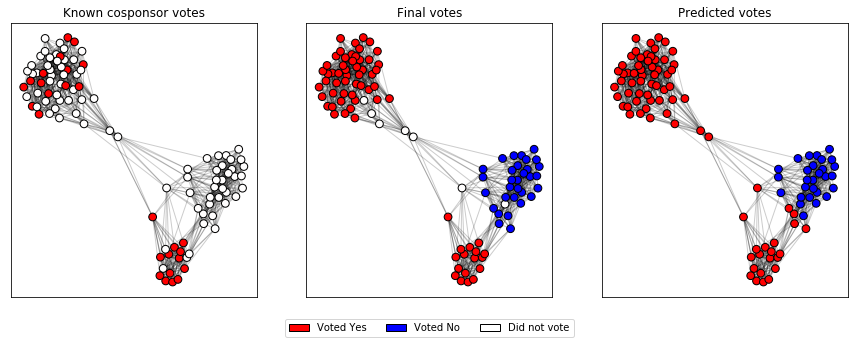

In [84]:
test_idx = 2
known_votes = X_test[test_idx]
true_votes = y_test[test_idx]

pred_votes_bin, t = predict_binarized_vote(known_votes, S, rf)

r_err = rel_err(true_votes, pred_votes_bin)
acc = compute_acc(true_votes, pred_votes_bin)

print('Relative error {:.2f}, accuracy {:.2f}% for threshold {:.5f}'.format(r_err, acc, t))
plot_predictions(known_votes, true_votes, pred_votes_bin, G, coords)

In this example, we have cosponsors in both parties saying Yes, but in one party they are very evenly distributed, while in the other they are only present in a small subcluster. We observe that our method nicely predicts that all members of the respective subclusters will say yes, while the subcluster without any cosponsors will say no.

### 2.3 Analysis of all congresses

The above code was tested with congress 115, but we cannot yet draw any conclusions about the accuracy of our model using only one congress. For this reason, we compute the accuracies and relative errors for all bills from congresses 105 to 115 (exlcuding 106, since the ProPublica API does not return the right data).

In [86]:
senate_ids = [105, 107, 108, 109, 110, 111, 112, 113, 114, 115]

accs_senates = {}
errs_senates = {}

for senate_id in senate_ids:
    print('Evaluating senate #{}'.format(senate_id))
    # Generate the train and test data
    data = get_train_test(senate_id=senate_id, ratio_train=0.5, ratio_val=0, shuffle=True)
    X_train, _, X_test, y_train, _, y_test = data
    # Generate the adjacency and incident matrix
    A = compute_adjacency(y_train)
    S = compute_incident_matrix(A)
    # Generate the train data for the random forest and train it
    features, ts, _, _ = generate_threshold_dataset(X_train, y_train, S)
    rf = RandomForestRegressor(criterion='mae')
    rf.fit(features, ts)
    # Evaluate the method and save accuracies and relative errors
    errs_test, accs_test = evaluate_method(X_test, y_test, S)
    accs_senates[senate_id] = accs_test
    errs_senates[senate_id] = errs_test
    
accs_senates = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in accs_senates.items() ]))
errs_senates = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in errs_senates.items() ]))

Evaluating senate #105
Evaluating senate #107
Evaluating senate #108
Evaluating senate #109
Evaluating senate #110
Evaluating senate #111
Evaluating senate #112
Evaluating senate #113
Evaluating senate #114
Evaluating senate #115


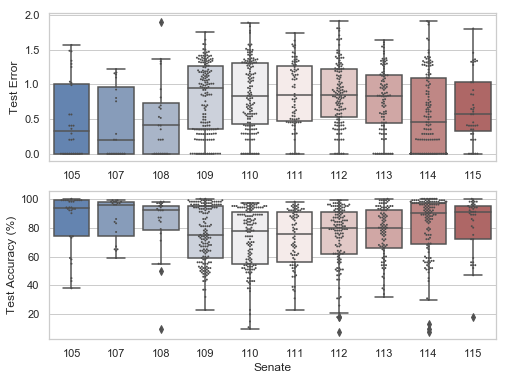

In [88]:
fig, ax= plt.subplots(2,1, figsize=(8,6))
sns.set(style="whitegrid")
sns.boxplot(data=errs_senates, palette="vlag", ax=ax[0])
sns.swarmplot(data=errs_senates, size=2, color=".3", ax=ax[0])
sns.boxplot(data=accs_senates, palette="vlag", ax=ax[1])
sns.swarmplot(data=accs_senates, size=2, color=".3", ax=ax[1])
ax[0].set_ylabel('Test Error')
ax[1].set_ylabel('Test Accuracy (%)')
plt.xlabel('Senate')
plt.savefig('./plots/test_err_transduct.pdf')

In [104]:
print('Mean accuracies:\n', accs_senates.mean(axis=0), 
      '\n\nStandard deviation:\n', accs_senates.std(axis=0))

Mean accuracies:
 105    84.666667
107    86.150000
108    82.291667
109    75.552147
110    72.352518
111    72.397436
112    74.519084
113    76.793814
114    81.418605
115    81.550000
dtype: float64 

Standard deviation:
 105    19.580661
107    14.557599
108    21.037191
109    19.212635
110    21.157403
111    19.238989
112    20.124364
113    17.643423
114    20.726530
115    19.327077
dtype: float64


In [102]:
print('Mean errors:\n', errs_senates.mean(axis=0), 
      '\n\nStandard deviation:\n', errs_senates.std(axis=0))

Mean errors:
 105    0.502389
107    0.448465
108    0.519673
109    0.817221
110    0.858676
111    0.866332
112    0.865657
113    0.803012
114    0.588375
115    0.660268
dtype: float64 

Standard deviation:
 105    0.553844
107    0.509856
108    0.529611
109    0.492659
110    0.488878
111    0.464404
112    0.444306
113    0.453903
114    0.551242
115    0.486879
dtype: float64


We are getting very high accuracies throughout all congresses, with the congresses 109 - 113 giving somewhat worse results. Particularly noteworthy is the fact, that the congresses with little training data (105, 107, 108, 115) still give very good results.

<hr>

## 3 Prediction Model: an application of Convolutional Neural Networks on Graphs

This code was inspired by the [Graph Conv Net] library, whose algorithm was proposed in the [paper] *Convolutional Neural Networks on Graphs with Fast Localized Spectral Filtering*. 

[Graph Conv Net]: https://github.com/mdeff/cnn_graph, 
[paper]: https://arxiv.org/abs/1606.09375

In [2]:
VOTES_PATH = './data/votes/votes_{}.csv'
BILLS_PATH = './data/bills/bills_{}.csv'
SEED = 123
np.random.seed(SEED)

The CNN code as proposed in the reference was adapted for the regression problem, using Mean Squared Error as cost function, for an input tensor of and label tensor of dimension $N_{tr}\times N_{s}$, where $N_{tr}$ is the training set length and $N_{s}$ is the number of senators. 

Further details on the changes made can bee seen in `lib/models_alt.py`.

In [3]:
params = dict()
params['dir_name'] = 'demo'
params['num_epochs'] = 200           # Number of training epochs
params['batch_size'] = 10            # Size of training batch
params['eval_frequency'] = 40        # Frequence of evaluation

# Building blocks.
params['filter'] = 'chebyshev5'      # Type of filter
params['brelu'] = 'b1relu'           # Type of activation function
params['pool'] = 'apool1'            # Type of pooling

# Architecture.
params['F'] = [32, 64]               # Number of graph convolutional filters.
params['p'] = [1, 1]                 # Pooling rate
params['K'] = [4, 4]                 # Polynomial degree
         
# Optimization.
params['regularization'] = 5e-4      # Regularization weight
params['dropout'] = 1                # 1- Dropout probability
params['decay_rate'] = 0.95          # Learning rate decay
params['momentum'] = 0               # Momentum
params['learning_rate'] = 0.1        # Learning rate

In [4]:
def compute_laplacian_list(A):
    '''
    Computes the normalized laplacian to use as input for the CNN.  
    '''
    L = [graph.laplacian(A, normalized=True) for i in range(2)]
    return L

def set_params_cnn(X_train, params):
    '''
    Sets parameters for the CNN.
    '''
    params['decay_steps']    = X_train.shape[0] / params['batch_size']
    params['M']              = [X_train.shape[1]]    
    return params

def run_CNN(L, params, X_train, y_train, X_val, y_val, print_flag=False):
    '''
    Trains CNN model.
    '''
    model = models_alt.cgcnn(L, **params)
    loss_train, loss_val, train_accs, val_accs, t_step = model.fit(X_train, y_train, X_val, y_val, print_flag)
    
    return loss_train, loss_val, train_accs, val_accs, model

def compute_set_accuracy(truth, preds):
    '''
    Computes the prediction accuracy for a set.
    
    Args:
        truth: Ground truth set
        preds: Estimated set
    '''
    not_vot = np.not_equal(truth, 0)
    a = np.equal(preds, truth)
    return np.sum(a[not_vot])/np.size(truth[not_vot])

def predict_labels(X):
    '''
    Predicts labels for the input set X.
    Args:
        X: input dataset
    '''
    Pred = model.predict(X)
    Pred = eval_prediction(Pred)

    return Pred

def compute_prediction_err_acc(Truth, Pred):
    '''
    Computes the prediction error and accuracy for each bill.
    Args:
        Truth: Ground truth signal matrix
        Preds: Estimated signal matrix
    '''
    err_v = []
    acc_v = []
    
    for i in range(Truth.shape[0]):
        acc_v.append(compute_acc(Truth[i], Pred[i]))
        err_v.append(rel_err(Truth[i], Pred[i]))
        
    return err_v, acc_v

def eval_prediction(Pred):
    '''
    Binarize predictions into 1 and -1.
    Args:
        Pred: predicted labels set.
    '''
    Pred_bool = (Pred-Pred.mean(axis=1)[:,np.newaxis])>0
    Pred[Pred_bool] = 1
    Pred[~Pred_bool] = -1
    return Pred

### 3.1 Example: Congress 115

In order to illustrate the use of the CNN applied to the senators graph, we consider the 115th Senate. As training input, half of the votes related to active bills are used, as well as graph (or its Laplacian) built from the training label vectors, i.e. from the actual votes outcome.

In this case, the number of senators is $N_{s} = 105$ (5 of them replaced other during the term).

The adjacency matrix is created from the similarity of votes between every two senators for the training set. This is done in function `compute_adjacency`, using the Euclidean distance measure.

In [5]:
X_train, X_val, X_test, y_train, y_val, y_test = get_train_test(senate_id = 115, shuffle = True)
A = compute_adjacency(y_train)
L = compute_laplacian_list(A)
params = set_params_cnn(X_train, params)
loss_train, loss_val, train_accs, val_accs, model = run_CNN(L, params, X_train, y_train, X_val, y_val, print_flag = False)

NN architecture
  input: M_0 = 105
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 105 * 32 / 1 = 3360
    weights: F_0 * F_1 * K_1 = 1 * 32 * 4 = 128
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 105 * 64 / 1 = 6720
    weights: F_1 * F_2 * K_2 = 32 * 64 * 4 = 8192
    biases: F_2 = 64
  layer 3: logits
    representation: M_3 = 105
    weights: M_2 * M_3 = 6720 * 105 = 705600
    biases: M_3 = 105


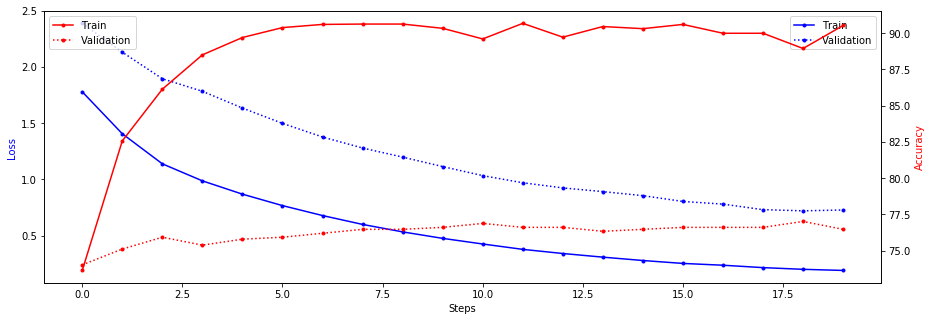

In [6]:
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(loss_train, 'b.-')
ax1.set_ylabel('Loss', color='b')
ax1.plot(loss_val, 'b.:')
ax1.legend(['Train', 'Validation'])
ax2 = ax1.twinx()
ax2.plot(train_accs, 'r.-')
ax2.set_ylabel('Accuracy', color='r')
ax2.plot(val_accs, 'r.:')
ax2.legend(['Train', 'Validation'])
ax1.set_xlabel('Steps')
plt.show()

We can see that the accuracy on the validation set reaches a score of $77$% by the end of the 200 training epochs. 

Now we perform the prediction over the test set, and illustrate it as:
- Red: Vote yes;
- Blue: Vote no;
- White: Did not vote.

In [7]:
Pred_train = predict_labels(X_train)
Pred_test = predict_labels(X_test)

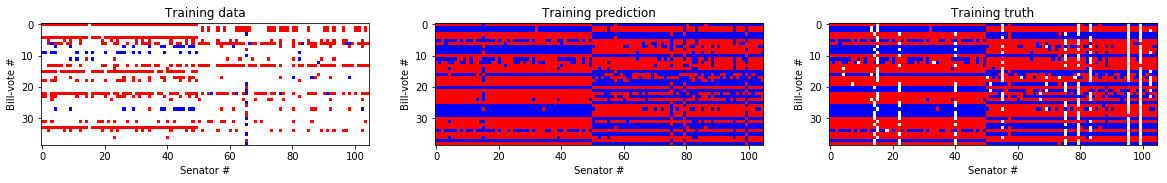

In [8]:
fig = plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(X_train, vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Senator #')
plt.ylabel('Bill-vote #')
plt.title('Training data')
plt.subplot(1,3,2)
plt.imshow(Pred_train, vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Senator #')
plt.ylabel('Bill-vote #')
plt.title('Training prediction')
plt.subplot(1,3,3)
plt.imshow(y_train, vmax = 1, vmin=-1, cmap = mycmap)
plt.xlabel('Senator #')
plt.ylabel('Bill-vote #')
plt.title('Training truth');

In [9]:
print('Accuracy train: {:.2f}%'.format(100*compute_set_accuracy(y_train, Pred_train)))

Accuracy train: 96.66%


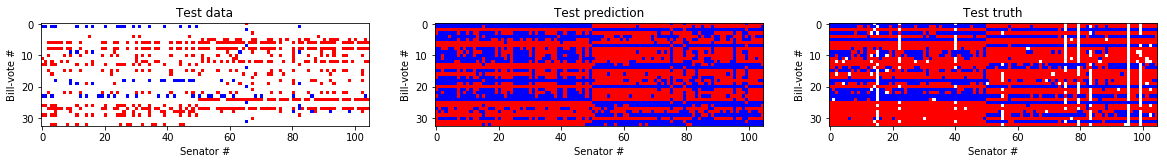

In [10]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(X_test, vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Senator #')
plt.ylabel('Bill-vote #')
plt.title('Test data')
plt.subplot(1,3,2)
plt.imshow(Pred_test, vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Senator #')
plt.ylabel('Bill-vote #')
plt.title('Test prediction')
plt.subplot(1,3,3)
plt.imshow(y_test, vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Senator #')
plt.ylabel('Bill-vote #')
plt.title('Test truth');

In [11]:
print('Accuracy test: {:.2f} %'.format(100*compute_set_accuracy(y_test, Pred_test)))

Accuracy test: 82.46 %


To better visualize the regression results, the following example is presented in network layout form, where one cosponsorship profile is selected among the validation set to emphasize the result predicted by the CNN and the respective groundtruth.

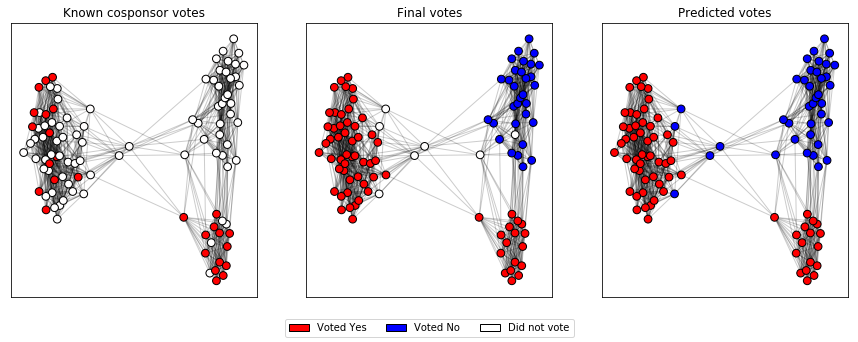

In [12]:
G = nx.from_numpy_matrix(A.todense())
coords = nx.spring_layout(G)

Pred_val = predict_labels(X_val)
plot_predictions(X_val[2], y_val[2], Pred_val[2], G, coords)
# plt.savefig('figs/net_cnn.pdf', bbox_inches = 'tight')

Note that the CNN is quite successfull in identifying the final vote pattern using as input the initial cosponsorship profile and the graph structure, resulting in an accuracy of 100% (since we do not consider absences in the prediction evaluation).

### 3.2 Analysis of all congresses

Next we extend the analysis to all US congresses, from Senate 105 to 115, where the same procedure detailed applied is for each of those Senates. The only exception is Senate 106, whose data provided by the ProPublica Congress API was inconsistent and faulty. 

In [13]:
Acc_tr = []
Acc_te = []
Err_tr = []
Err_te = []

for congress_nb in range(105, 116):
    if congress_nb != 106:
        X_train, X_val, X_test, y_train, y_val, y_test = get_train_test(senate_id = congress_nb, shuffle = True)
        A = compute_adjacency(y_train)
        L = compute_laplacian_list(A)
        params = set_params_cnn(X_train, params)
        loss_train, loss_val, train_accs, val_accs, model = run_CNN(L, params, X_train, y_train, X_val, y_val)
        Pred_train = predict_labels(X_train)
        Pred_test = predict_labels(X_test)

        err_tr, acc_tr = compute_prediction_err_acc(y_train, Pred_train)
        err_te, acc_te = compute_prediction_err_acc(y_test, Pred_test)

        Err_tr.append(err_tr)
        Err_te.append(err_te)
        Acc_tr.append(acc_tr)
        Acc_te.append(acc_te)
    

NN architecture
  input: M_0 = 100
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 100 * 32 / 1 = 3200
    weights: F_0 * F_1 * K_1 = 1 * 32 * 4 = 128
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 100 * 64 / 1 = 6400
    weights: F_1 * F_2 * K_2 = 32 * 64 * 4 = 8192
    biases: F_2 = 64
  layer 3: logits
    representation: M_3 = 100
    weights: M_2 * M_3 = 6400 * 100 = 640000
    biases: M_3 = 100
NN architecture
  input: M_0 = 101
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 101 * 32 / 1 = 3232
    weights: F_0 * F_1 * K_1 = 1 * 32 * 4 = 128
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 101 * 64 / 1 = 6464
    weights: F_1 * F_2 * K_2 = 32 * 64 * 4 = 8192
    biases: F_2 = 64
  layer 3: logits
    representation: M_3 = 101
    weights: M_2 * M_3 = 6464 * 101 = 652864
    biases: M_3 = 101
NN architecture
  input: M_0 = 100
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 100 * 32 / 1 = 3200


In [14]:
# Build dataframe with error and accuracy statistics for train and test sets.
c=0
df=pd.DataFrame()
for i in range(105, 116):
    if i != 106:
        df = df.append(pd.DataFrame(data=[Err_tr[c], Acc_tr[c], Err_te[c], Acc_te[c], [i for j in range(len(Err_tr[c]))]]).transpose())
        c+=1
df.columns = ['Err_tr', 'Acc_tr', 'Err_te', 'Acc_te', 'Congress']

Next we show the distribution of error and accuracy for the test set for each Senate. 

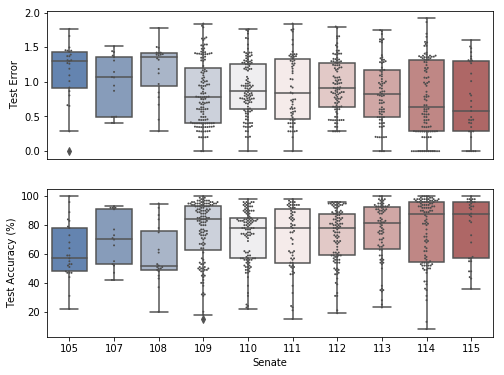

In [15]:
fig, ax= plt.subplots(2,1, figsize=(8,6))
sns.set(style="whitegrid")
sns.boxplot(x='Congress',y='Err_te', data=df, palette="vlag", ax=ax[0])
sns.swarmplot(x='Congress',y='Err_te', data=df, size=2, color=".3", ax=ax[0])
sns.boxplot(x='Congress',y='Acc_te', data=df, palette="vlag", ax=ax[1])
sns.swarmplot(x='Congress',y='Acc_te', data=df, size=2, color=".3", ax=ax[1])
ax[0].set_ylabel('Test Error')
ax[1].set_ylabel('Test Accuracy (%)')
ax[0].set_xticks([])
ax[0].set_xlabel('')

plt.xlabel('Senate')
plt.xticks(np.arange(10),[i for i in range(105,116) if i !=106]);
plt.savefig('figs/test_err_cnn.pdf')

We can see from the image above that for later Senates, the prediction accuracy tends to increase. This can be due to the fact that as the training data gets scarcer for the older Senates, the amount of information available may be insufficient to correctly train all parameters in the CNN. 

The mean training and test errors and accuracy scores, as well as their standard deviations, can be seen below:

In [16]:
df.groupby('Congress').mean()

,Err_tr,Acc_tr,Err_te,Acc_te
Congress,,,,
105.0,0.386327,88.137931,1.151240,61.560000
107.0,0.271573,93.950000,0.988657,69.250000
108.0,0.325602,88.875000,1.178439,59.200000
109.0,0.578014,84.717791,0.831039,75.923664
110.0,0.487341,83.920290,0.911905,72.053571
111.0,0.498713,83.974359,0.899211,71.000000
112.0,0.539656,83.816794,0.946748,72.400000
113.0,0.313680,90.906250,0.841079,75.512821
114.0,0.496464,84.232558,0.753823,76.500000


In [17]:
df.groupby('Congress').std()

,Err_tr,Acc_tr,Err_te,Acc_te
Congress,,,,
105.0,0.512123,16.715528,0.418507,19.564168
107.0,0.250460,3.817894,0.409836,19.014030
108.0,0.456948,12.546652,0.387927,19.845721
109.0,0.455819,16.612322,0.456652,21.106914
110.0,0.478867,17.847718,0.397389,18.778865
111.0,0.497312,18.258586,0.477156,22.230464
112.0,0.524954,19.095228,0.380953,18.812128
113.0,0.417772,12.065678,0.449047,20.268806
114.0,0.539125,19.274137,0.541947,22.719052
